<a href="https://colab.research.google.com/github/Pooret/inspiritai/blob/main/decoder_smiles_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 40.9 MB/s eta 0:00:00


In [2]:
# imports

import pandas as pd
import numpy as np
from tqdm import tqdm

import ast

from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType, Draw
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import PandasTools

In [3]:
# mount your drive to access your data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## In your google drive, there should be a `chembl_33_data.tar.gz` file. Locate that in the files tab on the left and copy and paste it's path into the line below.

 ### e.g. If the file pathway is `/content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz` the the code below will look this this:

 ### `!tar -xzf /content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz -C /content/`

In [4]:
!tar -xzf  /content/drive/MyDrive/Datasets/chemdata/Chembl_33_db/chembl_33_data.tar.gz -C /content/

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.provenance'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'


In [5]:
# load data into pandas dataframe
df = pd.read_csv("/content/data.csv")

# examine first 5 rows of data
df.head()

,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
0,10,c1cc2cc(c1)-c1cccc(c1)C[n+]1ccc(c3ccccc31)NCCC...,492214,IC50,110.0,nM,200081,104828,CHEMBL2547,Rattus norvegicus,...,0.17,606.3712,4.0,2.0,2.0,0.13,NaN,NaN,NaN,NaN
1,23,O=C1O/C(=C/Br)CCC1c1cccc2ccccc12,14394768,Potency,73078.0,nM,1301803,104173,CHEMBL6152,Trypanosoma brucei,...,0.72,316.0099,2.0,0.0,0.0,0.52,21.61,0.49,2.35,26.06
2,24,O=C1O/C(=C/I)CCC1c1cccc2ccccc12,294832,IC50,30.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,20.66,0.54,2.98,28.60
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.58,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70
4,26,O=C1O/C(=C\I)CCC1c1cccc2ccccc12,271844,IC50,190.0,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.55,363.9960,2.0,0.0,0.0,0.49,18.46,0.48,2.18,25.56


In [6]:
new_df = df[df['num_lipinski_ro5_violations'] < 1]

In [7]:
new_df['standard_type'].unique()

array(['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50',
       'ED50', 'Relative IC50', 'T50', 'Kieq', 'K bind', 'P-450 loss',
       'Kis', 'Activity', 'IC30', 'dP/dt', 'MIC90', 'fIC30', 'Protection',
       'Stability', 'Kd2', 'KiAH', 'C50', 'Ri', 'MEC', 'Rate',
       'Binding affinity', 'Plasma level', 'cKi', 'K0.5', 'fEC50',
       'Log Ki', 'Ke', 'CIC', 'Ka', 'IP', 'Ke naloxone', 'pKb', 'INH',
       'Plasma concentration', 'Residual activity', 'MI0.5', 'Ks',
       'K 0.5', 'Cytotoxicity', 'K app', 'KL', 'IC60', 'Log IC50', 'Kif',
       'SC200', 'EC20', 'KiH', 'Ca2+ elevation', 'Ratio Ki', 'K2',
       'alphaKi', 'MIC100', 'XI50', 'Inhibitory activity', 'Affinity',
       'Inflection point', 'Mortality', 'LD50', 'Fluorescence',
       'Ki app (inact

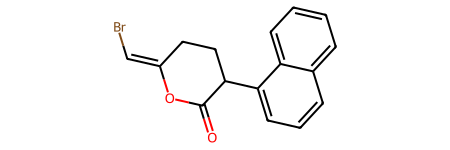

In [8]:
Chem.MolFromSmiles(df['canonical_smiles'].iloc[1])

In [9]:
(new_df['canonical_smiles'].iloc[0])

'O=C1O/C(=C/Br)CCC1c1cccc2ccccc12'

In [10]:
new_df.columns

Index(['molregno', 'canonical_smiles', 'activity_id', 'standard_type',
       'standard_value', 'standard_units', 'assay_id', 'tid',
       'target_chembl_id', 'organism', 'pref_name', 'mw_freebase', 'alogp',
       'hba', 'hbd', 'psa', 'rtb', 'ro3_pass', 'num_ro5_violations',
       'cx_most_apka', 'cx_most_bpka', 'cx_logp', 'cx_logd',
       'molecular_species', 'full_molformula', 'full_mwt', 'aromatic_rings',
       'heavy_atoms', 'qed_weighted', 'mw_monoisotopic', 'hba_lipinski',
       'hbd_lipinski', 'num_lipinski_ro5_violations', 'np_likeness_score',
       'bei', 'le', 'lle', 'sei'],
      dtype='object')

In [11]:
new_df['standard_type'].unique()

array(['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50',
       'ED50', 'Relative IC50', 'T50', 'Kieq', 'K bind', 'P-450 loss',
       'Kis', 'Activity', 'IC30', 'dP/dt', 'MIC90', 'fIC30', 'Protection',
       'Stability', 'Kd2', 'KiAH', 'C50', 'Ri', 'MEC', 'Rate',
       'Binding affinity', 'Plasma level', 'cKi', 'K0.5', 'fEC50',
       'Log Ki', 'Ke', 'CIC', 'Ka', 'IP', 'Ke naloxone', 'pKb', 'INH',
       'Plasma concentration', 'Residual activity', 'MI0.5', 'Ks',
       'K 0.5', 'Cytotoxicity', 'K app', 'KL', 'IC60', 'Log IC50', 'Kif',
       'SC200', 'EC20', 'KiH', 'Ca2+ elevation', 'Ratio Ki', 'K2',
       'alphaKi', 'MIC100', 'XI50', 'Inhibitory activity', 'Affinity',
       'Inflection point', 'Mortality', 'LD50', 'Fluorescence',
       'Ki app (inact

In [12]:
wanted_values = ['Potency', 'IC50', 'Kd', 'Ki', 'Solubility', 'Km', 'MIC', 'XC50',
       'Selectivity', 'Cmax', 'MIC80', 'MIC50', 'Kp', 'LC50', 'Kinact',
       'GI50', 'MCC', 'CC50', 'Kb', 'pKi', 'TGI', 'pA2', 'IC95', 'TC50',
       'EC50', 'Inhibition', 'ID50', 'fCmax', 'Ratio', 'IC90', 'AC50']

In [14]:
lip_df = new_df[(new_df['num_lipinski_ro5_violations'] == 0) & (new_df['hba_lipinski'] <= 10) & (new_df['mw_monoisotopic'] < 480) & (new_df['le']>0.3) & (new_df['lle']>3)]
print(lip_df.shape)
lip_df.head()



(118542, 38)


,molregno,canonical_smiles,activity_id,standard_type,standard_value,standard_units,assay_id,tid,target_chembl_id,organism,...,qed_weighted,mw_monoisotopic,hba_lipinski,hbd_lipinski,num_lipinski_ro5_violations,np_likeness_score,bei,le,lle,sei
3,25,C#C/C=C1\CCC(c2cccc3ccccc23)C(=O)O1,280316,IC50,95.0000,nM,156048,11934,CHEMBL3213,Homo sapiens,...,0.58,262.0994,2.0,0.0,0.0,0.52,26.77,0.48,3.24,26.70
5,31,COc1cc2nc(N3CCN(C(=O)C4CC4c4ccccc4)CC3)nc(N)c2...,325753,IC50,0.5129,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,0.66,433.2114,8.0,2.0,0.0,-0.89,21.43,0.40,6.61,9.90
6,33,COc1cc2nc(N3CCN(S(=O)(=O)c4cccs4)CC3)nc(N)c2cc1OC,343861,IC50,33.8800,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,0.65,435.1035,9.0,2.0,0.0,-1.78,17.15,0.35,5.67,6.74
20,59,COc1cc2nc(N3CCN(C(=O)CCc4ccccc4)CC3)nc(N)c2cc1OC,331005,IC50,3.3880,nM,33572,104304,CHEMBL1907610,Rattus norvegicus,...,0.65,421.2114,8.0,2.0,0.0,-0.91,20.10,0.37,5.96,9.03
21,60,COc1ccc(/C=C/C(=O)N2CCN(c3nc(N)c4cc(OC)c(OC)cc...,331003,IC50,3.3880,nM,33574,104304,CHEMBL1907610,Rattus norvegicus,...,0.57,449.2063,9.0,2.0,0.0,-0.67,18.84,0.35,5.87,8.22


Epoch 1/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 664s 742ms/step - accuracy: 0.8237 - loss: 0.6182 - val_accuracy: 0.9082 - val_loss: 0.2701
Epoch 2/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 241s 261ms/step - accuracy: 0.9090 - loss: 0.2671 - val_accuracy: 0.9213 - val_loss: 0.2266
Epoch 3/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 208s 269ms/step - accuracy: 0.9183 - loss: 0.2361 - val_accuracy: 0.9253 - val_loss: 0.2145
Epoch 4/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 196s 261ms/step - accuracy: 0.9229 - loss: 0.2213 - val_accuracy: 0.9285 - val_loss: 0.2044
Epoch 5/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 200s 269ms/step - accuracy: 0.9255 - loss: 0.2131 - val_accuracy: 0.9310 - val_loss: 0.1975
Epoch 6/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 200s 270ms/step - accuracy: 0.9277 - loss: 0.2064 - val_accuracy: 0.9321 - val_loss: 0.1940
Epoch 7/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 202s 269ms/step - accuracy: 0.9291 - loss: 0.2021 - val_accuracy: 0.9335 - val_loss: 0.1899
Epoch 8/30
741/741 ━━━━━━━━━━━━━━━━━━━━ 202s 269ms/step - accuracy: 0.9306 -

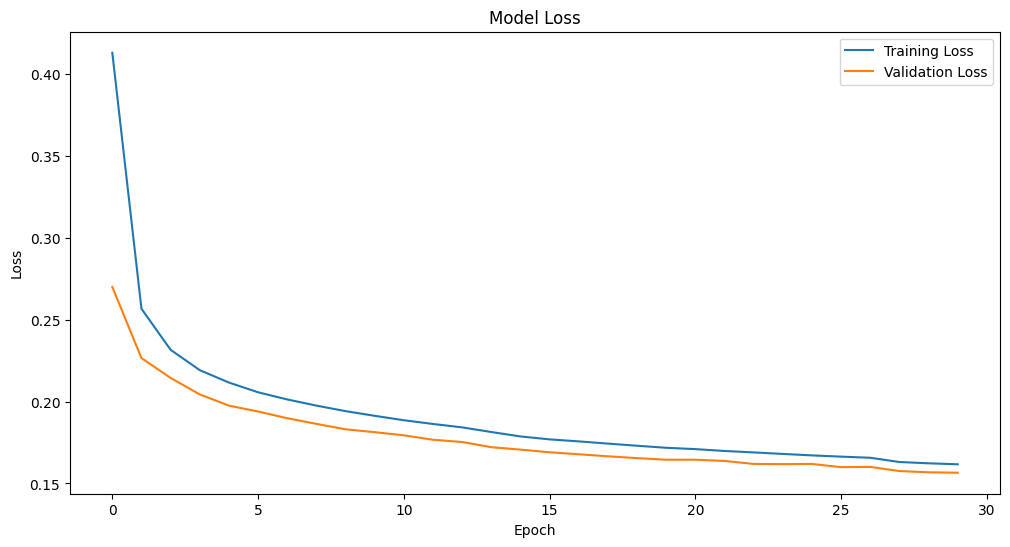

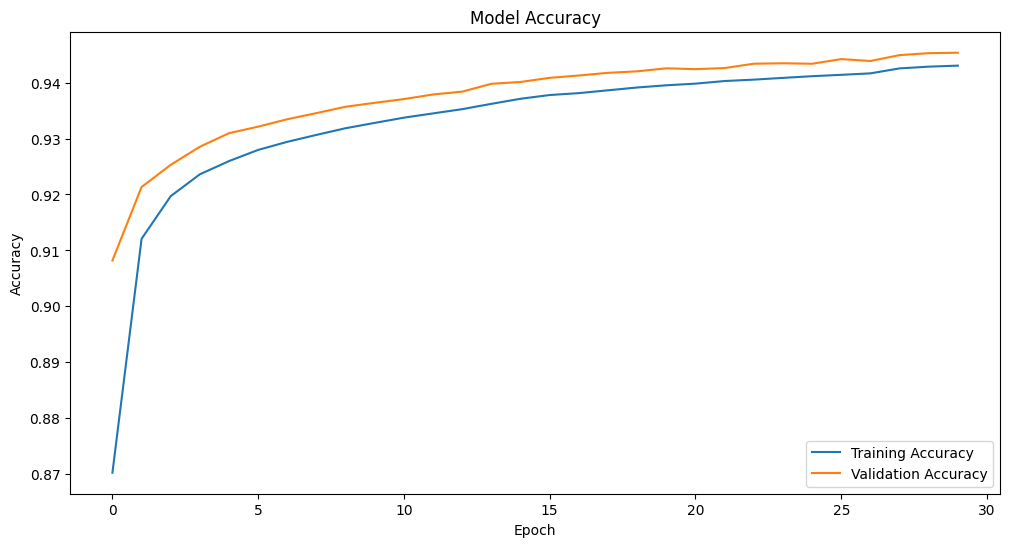

In [15]:
# Decoder only

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, Add, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Constants for the model
MODEL_DIM = 128
NUM_HEADS = 4
DROPOUT = 0.1
EPOCHS = 30
BATCH_SIZE = 128  # Adjust based on memory availability
LEARNING_RATE = 1e-3  # Adjusted learning rate
NUM_LAYERS = 8
TEMPERATURE = 1.0  # Temperature for generation
CLIPVALUE = 1.0  # Gradient clipping value

# Example SMILES list (assuming lip_df is defined elsewhere)
smiles_list = lip_df['canonical_smiles'].tolist()

# Add special tokens with reserved indices
special_tokens = ['<PAD>', '<SOS>', '<EOS>']
vocab = special_tokens + list(set("".join(smiles_list)))  # Ensure special tokens are at the beginning

# Create character-to-index and index-to-character mappings
chars_to_index = {char: index for index, char in enumerate(vocab)}
index_to_chars = {index: char for index, char in enumerate(vocab)}

# Define the maximum length for padding (adding 2 for the <SOS> and <EOS> tokens)
max_length = max(len(smiles) for smiles in smiles_list) + 2

# Encode all SMILES strings
encoded_smiles_list = [
    [chars_to_index['<SOS>']] + [chars_to_index[char] for char in smiles] + [chars_to_index['<EOS>']]
    for smiles in smiles_list
]

# Pad sequences to the same length using <PAD> token
padded_smiles_list = pad_sequences(encoded_smiles_list, maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])

# Convert to numpy array
X = np.array(padded_smiles_list)

# Create the target sequences (shifted by one time step)
y = np.zeros_like(X)
y[:, :-1] = X[:, 1:]
y[:, -1] = chars_to_index['<PAD>']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Positional Encoding Function
def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

# Build the GPT-like decoder-only model
def build_decoder_only_model(input_shape, vocab_size, model_dim, num_heads, dropout_rate, num_layers):
    inputs = Input(shape=input_shape)
    x = Embedding(input_dim=vocab_size, output_dim=model_dim, mask_zero=True)(inputs)

    # Add positional encoding
    pos_encoding = positional_encoding(input_shape[0], model_dim)
    x = Add()([x, pos_encoding[:, :input_shape[0], :]])

    for _ in range(num_layers):
        # Decoder block
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim)(x, x, attention_mask=tf.linalg.band_part(tf.ones((input_shape[0], input_shape[0])), -1, 0))
        attn_output = Dropout(dropout_rate)(attn_output)
        out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = Dense(model_dim, activation='relu')(out1)
        ffn_output = Dense(model_dim)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(x)
    model = Model(inputs, outputs)
    return model

# Instantiate the model
decoder_only_model = build_decoder_only_model(
    input_shape=(max_length,),
    vocab_size=len(vocab),
    model_dim=MODEL_DIM,
    num_heads=NUM_HEADS,
    dropout_rate=DROPOUT,
    num_layers=NUM_LAYERS
)

# Compile the model with gradient clipping
optimizer = Adam(learning_rate=ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
), clipvalue=CLIPVALUE)

decoder_only_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = decoder_only_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [16]:
# Function to generate SMILES strings with temperature scaling
def generate_smiles(model, start_token, max_length, chars_to_index, index_to_chars, temperature=1.0):
    # Initialize the input sequence with the start token
    input_seq = [chars_to_index[start_token]]
    for _ in range(max_length - 1):
        # Pad the sequence
        padded_seq = pad_sequences([input_seq], maxlen=max_length, padding='post', value=chars_to_index['<PAD>'])
        # Predict the next character
        pred = model.predict(padded_seq, verbose=0)
        pred = pred[0][len(input_seq) - 1]

        # Apply temperature scaling
        pred = np.log(pred + 1e-9) / temperature
        exp_pred = np.exp(pred)
        pred = exp_pred / np.sum(exp_pred)
        next_char = np.random.choice(len(pred), p=pred)
        # Append the next character to the sequence
        input_seq.append(next_char)
        # If EOS token is generated, stop the generation
        if next_char == chars_to_index['<EOS>']:
            break
    # Convert the sequence of indices to characters
    smiles = ''.join([index_to_chars[i] for i in input_seq if i != chars_to_index['<PAD>'] and i != chars_to_index['<EOS>']])
    print(smiles.split("<SOS>")[-1])
    return smiles.split("<SOS>")[-1]

def evaluate_generated_smiles(generated_smiles_list):
    from rdkit import Chem
    from rdkit import RDLogger

    # Function to check the validity of generated SMILES strings using RDKit
    def is_valid_smiles(smiles):
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None

    # Suppress RDKit warnings
    RDLogger.DisableLog('rdApp.*')

    valid_smiles = []

    for smiles in generated_smiles_list:
        if is_valid_smiles(smiles) and len(smiles) > 0:
            valid_smiles.append(smiles)

    validity = len(valid_smiles) / len(generated_smiles_list) * 100
    unique = len(list(set(valid_smiles))) / len(valid_smiles) * 100

    # Re-enable RDKit warnings if needed
    RDLogger.EnableLog('rdApp.*')

    return validity, unique, list(set(valid_smiles))

# Generate a new SMILES string
new_smiles = generate_smiles(decoder_only_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
print(f"Generated SMILES: {new_smiles}")
generated_smiles_list = []
for i in tqdm(range(100)):
    generated_smiles = generate_smiles(decoder_only_model, start_token='<SOS>', max_length=max_length, chars_to_index=chars_to_index, index_to_chars=index_to_chars, temperature=TEMPERATURE)
    generated_smiles_list.append(generated_smiles)

validity, uniqueness, unique_valid_smiles = evaluate_generated_smiles(generated_smiles_list)
print(f"\nPercent valid: {validity:.3f}%")
print(f"Percent unique: {uniqueness:.3f}%")
print(unique_valid_smiles)

O=C(Cn1nccn1)Nc1ccc(Cc2nccc(-c3cccs3)n2)cc1I
Generated SMILES: O=C(Cn1nccn1)Nc1ccc(Cc2nccc(-c3cccs3)n2)cc1I


  1%|          | 1/100 [00:01<01:58,  1.19s/it]

O=C1NCCc2[nH]ccc21


  2%|▏         | 2/100 [00:03<02:32,  1.56s/it]

Fc1ccc(OC[C@@H]2CCCN2)c(O)c1


  3%|▎         | 3/100 [00:06<03:49,  2.37s/it]

Cc1noc(C)c1CCC(NS(=O)(=O)c1ccc(OCC(F)(F)F)nc1)C(=O)O


  4%|▍         | 4/100 [00:09<04:09,  2.60s/it]

CC(C)c1c(C(=O)NC[C@@H]2CCO2)n(CC2CC2)c2ccccc12


  5%|▌         | 5/100 [00:13<04:51,  3.07s/it]

CCC[C@H](COC)n1cnc2c(N)nc(Nc3cc(Br)ccc3OC)nc21


  6%|▌         | 6/100 [00:17<05:22,  3.43s/it]

Cc1cc2c(cc1Cl)N(C(=O)N1C[C@@]3CCC[C@H]1C3(C)[C@@H](O)C2)CC2


  7%|▋         | 7/100 [00:19<04:47,  3.10s/it]

O=C1Cc2cnc(Nc3cccc(Cl)c3)nc2-c2cccnc2N1


  8%|▊         | 8/100 [00:23<05:04,  3.31s/it]

COC(=O)c1ccc(C)c(S(=O)(=O)CC2(C(=O)NO)CCN(Cc3ccccc3)CC2)c1


  9%|▉         | 9/100 [00:26<04:52,  3.22s/it]

CC(C)Cc1c(OCc2cccc(F)c2)ccc2nc(N)nc(N)c12


 10%|█         | 10/100 [00:31<05:36,  3.73s/it]

CCn1c(=O)c2c(nc(/C=C/c3ccc(OC)c(OCC(F)(F)F)c3)n2C)n(CCC)c1=O


 11%|█         | 11/100 [00:35<05:38,  3.81s/it]

CC(=O)N1CC2(CC(N3CCN(c4ccc5c(c4)OC[C@H](N)C5)CC3)CC2)c2ccccc21


 12%|█▏        | 12/100 [00:39<05:31,  3.77s/it]

CCN(CC)CCOc1ccc(-n2nc(C(F)(F)F)cc2-c2ccc(S(N)(=O)=O)cc2)cc1


 13%|█▎        | 13/100 [00:42<05:26,  3.76s/it]

CC(C)NC(=O)Nc1ccc2ccn(S(=O)(=O)c3cccc4cccnc34)c2c1


 14%|█▍        | 14/100 [00:46<05:12,  3.63s/it]

COC(=O)[C@@H]1CCCNC[C@@H]1C(=O)N1CCCC


 15%|█▌        | 15/100 [00:49<05:10,  3.66s/it]

CC[C@H](Nc1c(Nc2cccc(C(=O)N(C)C)c2O)c(=O)c1=O)c1ccc(Cl)o1


 16%|█▌        | 16/100 [00:51<04:27,  3.18s/it]

CCN(C)2C(=O)N(C)c3cc(F)ccc3CC1C2


 17%|█▋        | 17/100 [00:55<04:29,  3.24s/it]

CCCCCCN1CC[C@H](NC(=O)CN(c2ccc3ccccc3c2)c2ccccc2)C1=O


 18%|█▊        | 18/100 [00:58<04:30,  3.30s/it]

O=c1cc(N2CCOCC2)oc2cc(OCc3ccc4ccccc4c3)ccc12


 19%|█▉        | 19/100 [01:02<04:30,  3.34s/it]

O=C1NCc2cc3cc(OCCCNc4cccc(O)c4)ccc3oc21


 20%|██        | 20/100 [01:06<04:39,  3.49s/it]

O=C(Cn1c2c(c(=O)[nH]c1=O)CSCC2)NC12C[C@@H]3C[C@H](C1)C(C3)C2


 21%|██        | 21/100 [01:07<03:56,  3.00s/it]

O=P(O)(O)/C=C/c1ccc(F)c(F)c1


 22%|██▏       | 22/100 [01:11<04:08,  3.19s/it]

Cc1cccc(S(=O)(=O)N(Cc2ccccc2C)[C@H]2[C@@H]3CCC[C@H]2C3)c1


 23%|██▎       | 23/100 [01:15<04:15,  3.32s/it]

COC1CCN([C@@H]2CN[C@@H](C(=O)N3CCSC3)C2)CC1


 24%|██▍       | 24/100 [01:18<04:06,  3.24s/it]

O=C(O)c1cnc2c(cnn2S(=O)(=O)c2ccccc2)c1


 25%|██▌       | 25/100 [01:19<03:19,  2.67s/it]

O=C1NCCN1C[C@H]1CCCO1


 26%|██▌       | 26/100 [01:21<03:04,  2.49s/it]

O=C(Cc1csc(NC(=O)Nc2ccccc2)n1)NO


 27%|██▋       | 27/100 [01:24<03:12,  2.64s/it]

COC(=O)N1CCC(COc2nc(N)nc(-c3ccc(C#N)cc3)n2)CC1


 28%|██▊       | 28/100 [01:26<03:00,  2.51s/it]

Oc1nc2c(c3c(CCc4ccccc4)cccc13)CNCC2


 29%|██▉       | 29/100 [01:28<02:41,  2.27s/it]

O=C(O)c1cc2nccc(O)c2cn1


 30%|███       | 30/100 [01:32<03:18,  2.83s/it]

CNC(=O)Cn1c(=O)n(C2CCCCC2)c2ncnc(NCc3ccccc3)c21


 31%|███       | 31/100 [01:35<03:15,  2.83s/it]

COc1ccc(C#C/C(O)=C\C(=O)CCCCc2ccccc2)cc1N


 32%|███▏      | 32/100 [01:39<03:27,  3.05s/it]

Nc1cc(N)c2nc(CN3CCN(c4ccco4)[C@H](C(=O)N4CCSC4)C3)ccc2c1


 33%|███▎      | 33/100 [01:41<03:20,  2.99s/it]

C[C@@H]1CCCN1CCCOc1ccc(-c2ccc(-c3cccnc3)nc2)cc1


 34%|███▍      | 34/100 [01:44<03:17,  2.99s/it]

Br.COC(c1ccc(OCCCF)cc1)C1CCN(Cc2cccnc2)CC1


 35%|███▌      | 35/100 [01:46<02:56,  2.72s/it]

NCc1ccc(S(N)(=O)=O)cc1


 36%|███▌      | 36/100 [01:49<02:48,  2.64s/it]

c1ccc(-c2noc(CCN3CCCCC3)n2)cc1


 37%|███▋      | 37/100 [01:51<02:32,  2.42s/it]

CCCCC(=O)c1ccc(OS(N)(=O)=O)cc1


 38%|███▊      | 38/100 [01:54<02:51,  2.76s/it]

COc1cccc(CN2C(=O)c3ccc(NC(=O)S(=O)(=O)c4cccs4)cc3C2=O)c1


 39%|███▉      | 39/100 [01:58<03:13,  3.17s/it]

CC(C)C[C@H](CC(=O)NO)C(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)O)C(C)(C)C


 40%|████      | 40/100 [02:01<03:02,  3.03s/it]

Cc1cccc(-c2cc(Nc3ccccc3)[nH]n2)c1


 41%|████      | 41/100 [02:04<02:59,  3.04s/it]

C[C@@H](O)/N=C1\CN2CCC1CC2


 42%|████▏     | 42/100 [02:07<02:50,  2.94s/it]

O=C1NCCNC(=O)N1CCN1CCN(c2noc3ccccc23)CC1


 43%|████▎     | 43/100 [02:09<02:23,  2.52s/it]

Oc1nc2cccnc2n1-c1ccccc1


 44%|████▍     | 44/100 [02:12<02:40,  2.86s/it]

Clc1ccc(CCCN2CCCN(CCCCc3c[nH]c4ccc(-n5cnnc5)cc34)CC2)cc1


 45%|████▌     | 45/100 [02:14<02:17,  2.51s/it]

CC(C)c1nnc2c3ccccc3n(C)c12


 46%|████▌     | 46/100 [02:17<02:22,  2.64s/it]

O=P(O)(O)CCCCN1C(c2ccccc2)C2CCC1C1C2


 47%|████▋     | 47/100 [02:22<03:04,  3.48s/it]

Cc1ccc(C(=O)OC[C@@]2(CO)[C@@H]3CO[C@H](CO)[C@@H]3C[C@H]2OC(=O)NCC#N)cn1


 48%|████▊     | 48/100 [02:25<02:43,  3.15s/it]

CC(C)[C@](C)(CS)C(=O)NCCc1ccc(Cl)cc1


 49%|████▉     | 49/100 [02:28<02:42,  3.18s/it]

CCCN[C@@H](C(=O)N1CCC[C@H]1C(=O)NCc1ccccc1)c1ccccc1


 50%|█████     | 50/100 [02:32<02:55,  3.51s/it]

N[C@@H](CC(=O)N1CCc2cc(C(=O)N3CCCCC3)ccc21)Cc1cc(F)ccc1F


 51%|█████     | 51/100 [02:35<02:36,  3.19s/it]

C=C1COc2c(ccc3oc(O)cc23)O1


 52%|█████▏    | 52/100 [02:38<02:34,  3.22s/it]

Cl.NS(=O)(=O)c1ccc(CCCCCCOc2ccc(Oc3ccccc3)cc2)cc1


 53%|█████▎    | 53/100 [02:41<02:27,  3.14s/it]

CCO[P@@](=O)(c1ccc(F)cc1)N1c2cccnc2C[C@@]1(C)C


 54%|█████▍    | 54/100 [02:44<02:20,  3.06s/it]

CCCC(=O)N(CP(=O)(O)O)CC1CCc2c(ccc3ccccc23)C1


 55%|█████▌    | 55/100 [02:46<02:13,  2.96s/it]

CC(C)c1cc(Cl)cc(S(=O)(=O)N2CCCCC2)c1


 56%|█████▌    | 56/100 [02:50<02:13,  3.03s/it]

Nc1ncnc2c1c(-c1ccc(Br)cc1)nn2C1CCCO1


 57%|█████▋    | 57/100 [02:54<02:28,  3.46s/it]

CN1CC=C(c2c[nH]c3ccc(-c4cnc(N)c(C5(CCNCC5)C5)nc4)cc23)C2CCCC12


 58%|█████▊    | 58/100 [02:56<02:09,  3.09s/it]

CCOc1cc(Cc2cnc(N)nc2N)cc(OCCC)c1OCC


 59%|█████▉    | 59/100 [02:58<01:54,  2.78s/it]

CC(N)Cc1c2c(c(F)c3c1OCC3)OCC2.Cl


 60%|██████    | 60/100 [03:01<01:44,  2.61s/it]

O=c1[nH]c(-c2ccc(F)cc2)nc2ncccc12


 61%|██████    | 61/100 [03:05<02:03,  3.17s/it]

CNC(=O)N(O)C[C@@H](c1ccccc1)P(=O)([O-])c1ccccc1.[Na+]


 62%|██████▏   | 62/100 [03:09<02:08,  3.37s/it]

Cc1ccc(C(=O)c2[nH]cc([C@@H]3CCC[C@H]3N)c2C(C)=O)cc1


 63%|██████▎   | 63/100 [03:12<01:57,  3.17s/it]

O=C(NO)O[C@]12COCC=C1C[C@H](Oc1cccnc1)C2


 64%|██████▍   | 64/100 [03:14<01:49,  3.04s/it]

Cc1c(Cl)nc(Nc2ccc(N3CCOCC3)cc2)nc1N1CCCC1


 65%|██████▌   | 65/100 [03:16<01:34,  2.70s/it]

CC(C)CC(C(=O)Nc1ccccc1)C(=O)NO


 66%|██████▌   | 66/100 [03:19<01:28,  2.60s/it]

CC(N)Cc1c2c(c(Br)c3c1OCC3)OCC2


 67%|██████▋   | 67/100 [03:22<01:36,  2.93s/it]

COC(=O)c1ccc2c(c1)OC(c1cc(F)c(F)cc1F)CN2


 68%|██████▊   | 68/100 [03:25<01:31,  2.85s/it]

Cc1ccccc1C#Cc1cc(N2CCCC2)nc(Nc2ccccc2)n1


 69%|██████▉   | 69/100 [03:29<01:35,  3.07s/it]

O=C(c1ccc(Cl)c(Cl)c1)N1CCC(N2CCN(Cc3cccc(Cl)c3)CC2)CC1


 70%|███████   | 70/100 [03:30<01:20,  2.67s/it]

O=C(O)CC(Cc1ccccc1)C(=O)O


 71%|███████   | 71/100 [03:35<01:32,  3.18s/it]

CCCCCC(=O)N1CCC(n2c(=O)[nH]c3nc(-c4ccncc4)nc(NC4CC4)c32)CC1


 72%|███████▏  | 72/100 [03:37<01:23,  2.97s/it]

Cl.N=C(N)N/N=C/c1ccc(O)cc1O


 73%|███████▎  | 73/100 [03:40<01:20,  2.97s/it]

O=C1NCCS/C1=C\c1cc2cc[nH]c(=O)c2[nH]1


 74%|███████▍  | 74/100 [03:43<01:12,  2.80s/it]

OCCn1cnc(-c2ccc([N+](=O)[O-])s2)c1


 75%|███████▌  | 75/100 [03:47<01:24,  3.39s/it]

Cc1cccc(C(=O)Nc2noc(CC(=O)N[C@H]3C(=O)c4ccccc4[N+]3(=O)[O-])n2)c1C.[Br-]


 76%|███████▌  | 76/100 [03:51<01:23,  3.48s/it]

Nc1cc(-c2cnc3ccccc3n2)nc2c(Nc3ccccc3F)ncnc12


 77%|███████▋  | 77/100 [03:54<01:17,  3.38s/it]

CCCc1nc(-c2ccccc2)nc(NC2CCCC2)n1


 78%|███████▊  | 78/100 [03:58<01:15,  3.43s/it]

COC(=O)[C@H]1C2CCC(C[C@@H]1OC(=O)c1ccc3[nH]ncc3c1)N2C


 79%|███████▉  | 79/100 [04:00<01:05,  3.12s/it]

CCCNS(=O)(=O)c1ccc2c(C(F)(F)F)cccc2c1


 80%|████████  | 80/100 [04:03<01:01,  3.08s/it]

NS(=O)(=O)c1ccc(NC(=O)c2ccccc2S(N)(=O)=O)cc1


 81%|████████  | 81/100 [04:05<00:52,  2.77s/it]

S=C([S-])NCc1ccccc1.[Na+]


 82%|████████▏ | 82/100 [04:09<00:55,  3.09s/it]

Cl.Cl.OC1CCN(CCc2sc(Cl)nc2-c2ccc(O)cc2)CC1


 83%|████████▎ | 83/100 [04:11<00:46,  2.73s/it]

CCCCN1C(=O)C2CCCCC2C1=O


 84%|████████▍ | 84/100 [04:14<00:46,  2.93s/it]

CN1C(=O)C(NC(=O)Nc2ccccc2)N=C(c2ccccc2Cl)c2ccccc21


 85%|████████▌ | 85/100 [04:20<00:58,  3.88s/it]

O=C(O)C[C@@]1(C(=O)O)[C@@](c2ccc(Cl)c(Cl)c2)(c2ccc(C(=O)O)c(C(F)(F)F)c2)O[C@H]1C(F)(F)F


 86%|████████▌ | 86/100 [04:25<00:58,  4.17s/it]

C[C@]12CCC(=Cc3c(C#N)c(NC(=O)c4cccnc4)ncc31)CC[C@@H]2C


 87%|████████▋ | 87/100 [04:28<00:50,  3.87s/it]

Cc1sc(NC(=O)/C(C#N)=C(\O)C2CCCC2)nc1Cc1ccccc1


 88%|████████▊ | 88/100 [04:33<00:48,  4.03s/it]

CN1[C@H](C(=O)N2CCC[C@H]2C#N)[C@@H]2C[C@@H]2[C@H]1C(=O)N3CCc1ccccc1


 89%|████████▉ | 89/100 [04:35<00:38,  3.51s/it]

CC(=O)OC[C@@H]1CCCC[C@]11OCCC(=O)O


 90%|█████████ | 90/100 [04:39<00:36,  3.66s/it]

CN(Cc1ccc(Cl)cc1Cl)CC(=O)Nc1ccc(Cl)cc1S(N)(=O)=O


 91%|█████████ | 91/100 [04:43<00:34,  3.80s/it]

Oc1ccc2c3c1O[C@H](/C(=C/CCN1CCN(c4cccnc4Cl)CC1)C3)CO4


 92%|█████████▏| 92/100 [04:46<00:28,  3.61s/it]

COc1ccccc1N1CCN(CCCOC(=O)c2cccc(-n3cccn3)n2)CC1


 93%|█████████▎| 93/100 [04:48<00:22,  3.15s/it]

Nc1nc(NCCc2ccco2)c2c(O)cccc2n1


 94%|█████████▍| 94/100 [04:51<00:17,  2.92s/it]

O=C1c2ccccc2C(=O)c2cc(OCc3ccccc3)ccc21


 95%|█████████▌| 95/100 [04:54<00:14,  2.92s/it]

CNc1nc(-c2cn(CC#N)cn2)cc(NC2CCCC2)n1


 96%|█████████▌| 96/100 [04:58<00:12,  3.22s/it]

CN(Cc1cccc2cnccc12)C(=O)C(=O)N1CCCC1C(=O)O


 97%|█████████▋| 97/100 [05:01<00:09,  3.25s/it]

CNC(=O)Oc1ccc2c(c1)[C@@]13CCCC1[C@H](C2)N(C)C(=O)C3


 98%|█████████▊| 98/100 [05:04<00:06,  3.19s/it]

CC12CCC(C(O)(c3ccco3)c3ncccc31)[C@H]1C2CCC(C1)N2C


 99%|█████████▉| 99/100 [05:06<00:02,  2.71s/it]

CN1C[C@@H]2CCC[C@H]2C1


100%|██████████| 100/100 [05:08<00:00,  3.09s/it]

CC(C)(C)c1ccc(C(=O)NCCCc2c[nH]cn2)cc1

Percent valid: 88.000%
Percent unique: 100.000%
['CNc1nc(-c2cn(CC#N)cn2)cc(NC2CCCC2)n1', 'O=P(O)(O)/C=C/c1ccc(F)c(F)c1', 'C[C@@H](O)/N=C1\\CN2CCC1CC2', 'CC(C)NC(=O)Nc1ccc2ccn(S(=O)(=O)c3cccc4cccnc34)c2c1', 'CCCCCC(=O)N1CCC(n2c(=O)[nH]c3nc(-c4ccncc4)nc(NC4CC4)c32)CC1', 'CCO[P@@](=O)(c1ccc(F)cc1)N1c2cccnc2C[C@@]1(C)C', 'COC(=O)N1CCC(COc2nc(N)nc(-c3ccc(C#N)cc3)n2)CC1', 'CNC(=O)N(O)C[C@@H](c1ccccc1)P(=O)([O-])c1ccccc1.[Na+]', 'CC[C@H](Nc1c(Nc2cccc(C(=O)N(C)C)c2O)c(=O)c1=O)c1ccc(Cl)o1', 'COC(=O)c1ccc(C)c(S(=O)(=O)CC2(C(=O)NO)CCN(Cc3ccccc3)CC2)c1', 'CC(C)Cc1c(OCc2cccc(F)c2)ccc2nc(N)nc(N)c12', 'CN(Cc1cccc2cnccc12)C(=O)C(=O)N1CCCC1C(=O)O', 'N[C@@H](CC(=O)N1CCc2cc(C(=O)N3CCCCC3)ccc21)Cc1cc(F)ccc1F', 'CCN(CC)CCOc1ccc(-n2nc(C(F)(F)F)cc2-c2ccc(S(N)(=O)=O)cc2)cc1', 'COc1ccccc1N1CCN(CCCOC(=O)c2cccc(-n3cccn3)n2)CC1', 'CC(C)CC(C(=O)Nc1ccccc1)C(=O)NO', 'Cl.NS(=O)(=O)c1ccc(CCCCCCOc2ccc(Oc3ccccc3)cc2)cc1', 'Cc1ccccc1C#Cc1cc(N2CCCC2)nc(Nc2ccccc2)n1', 'CC(C)c1c(C(=O)N

In [17]:
decoder_only_model.save("/content/drive/MyDrive/InspiritAI/1:1Mentorship/sanjay_oruganti/TD_128_L8_H4.keras")

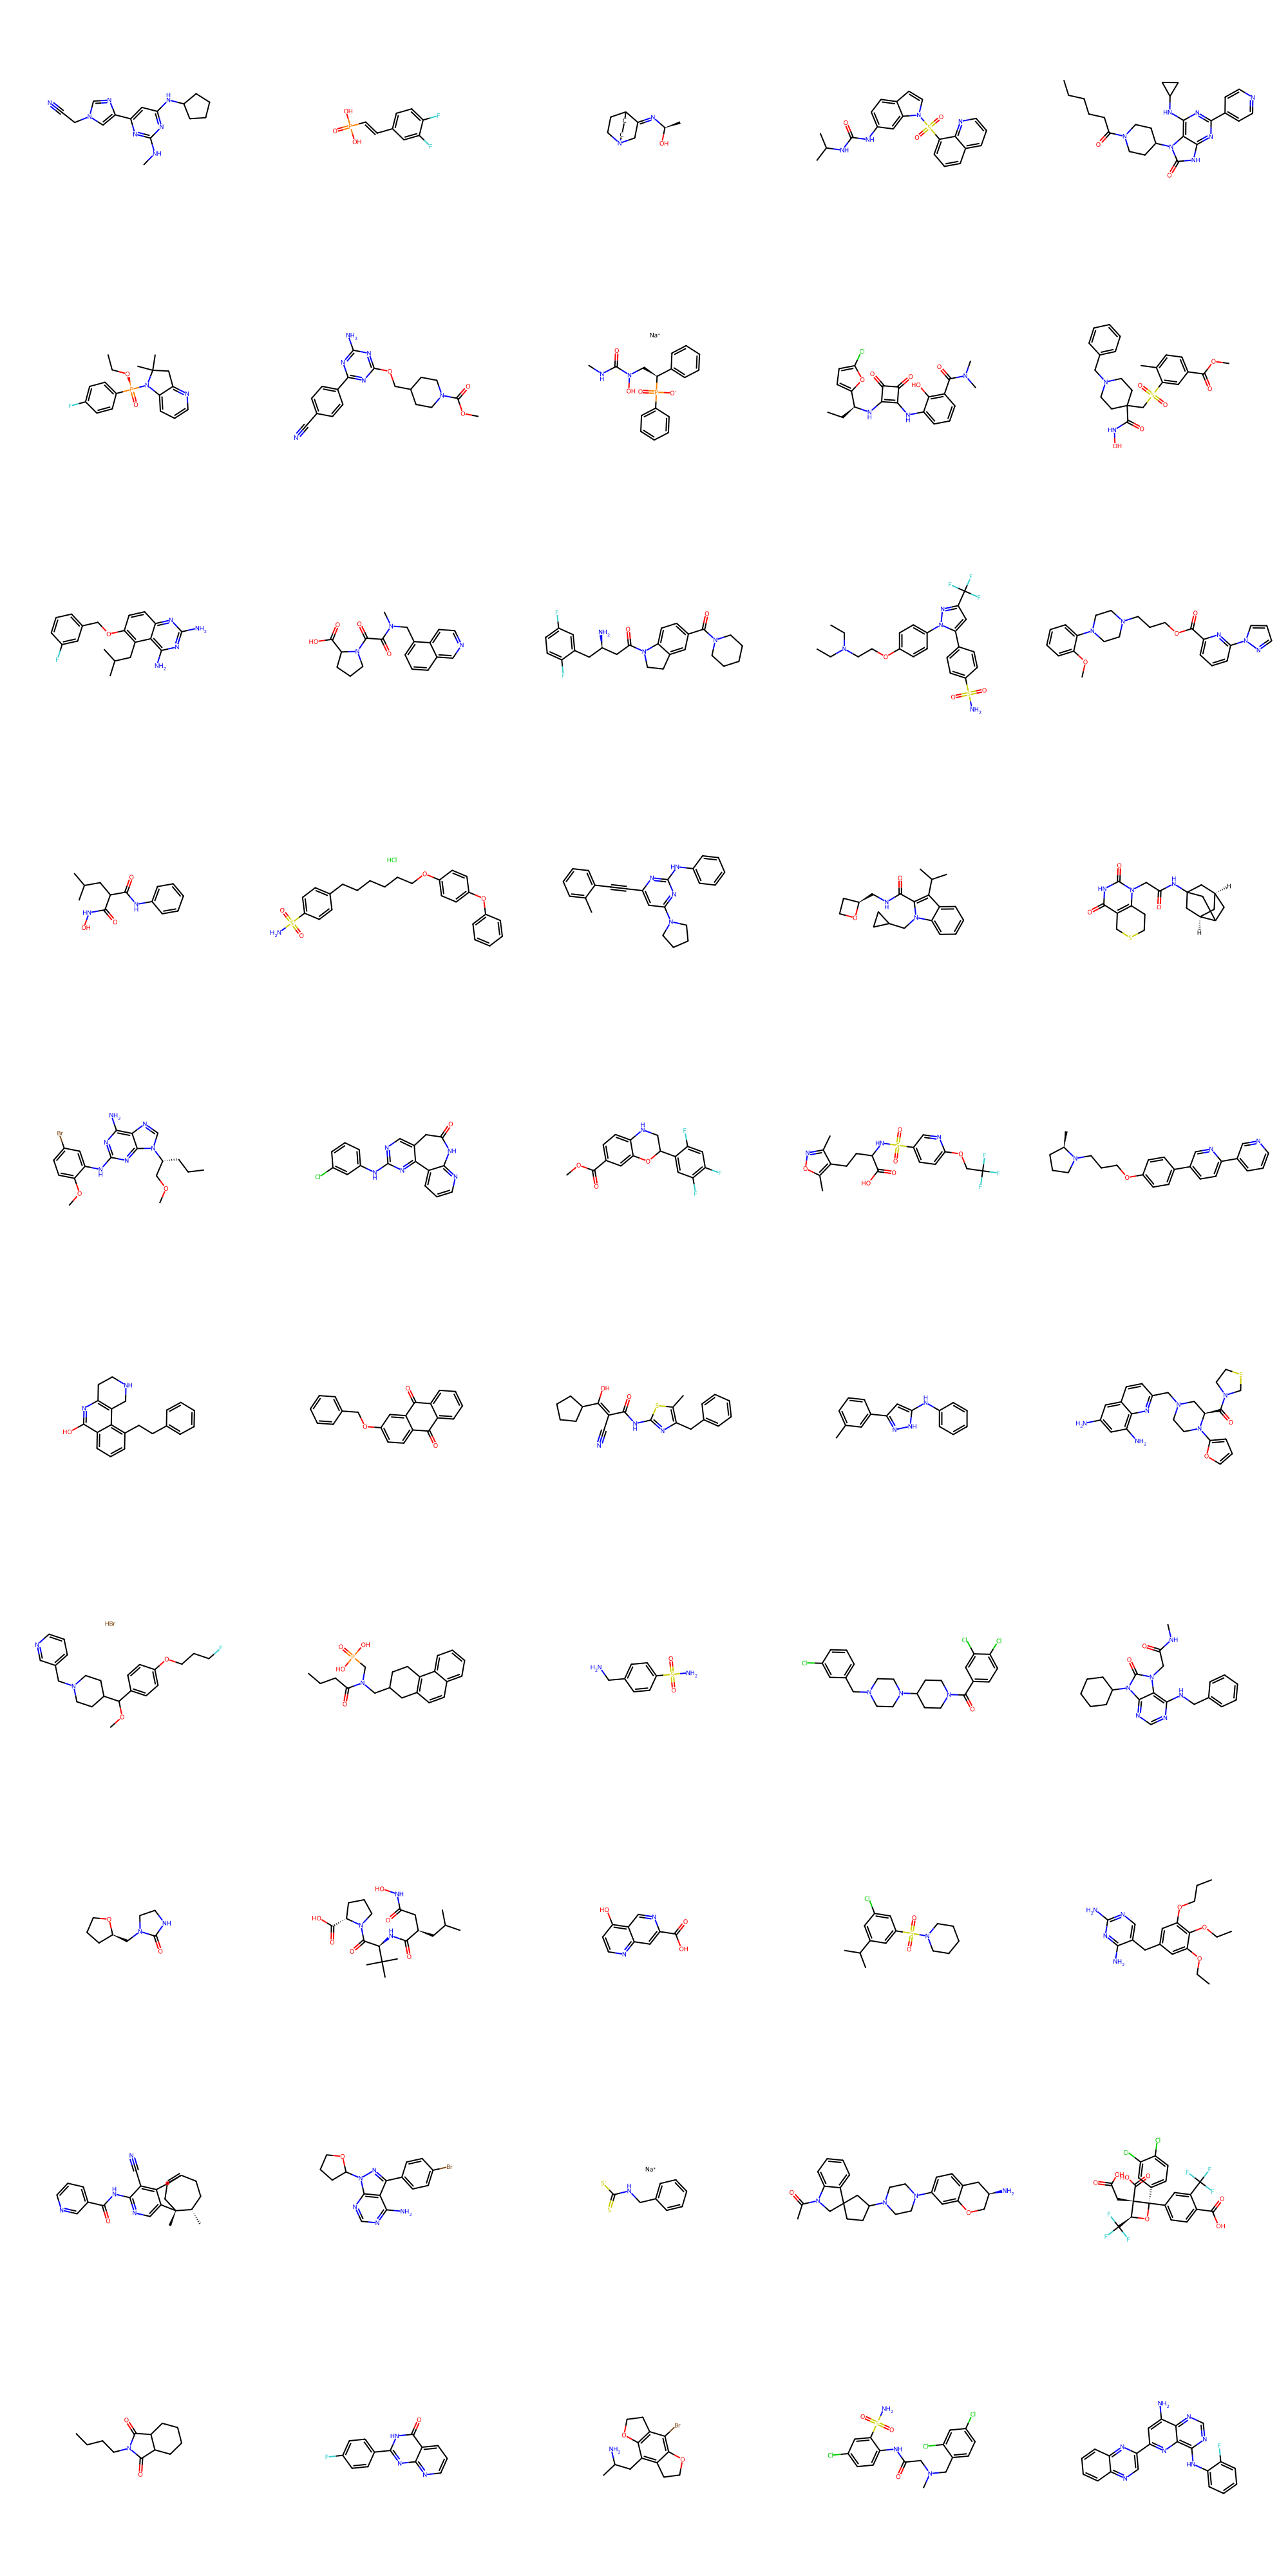

In [24]:
# Example: Display the first 10 unique valid SMILES strings as a grid image
molecule_list = [Chem.MolFromSmiles(smiles) for smiles in unique_valid_smiles[:50]]

# Generate a grid image of the molecules
# Adjust 'subImgSize' for the size of each molecule image, and 'molsPerRow' for the layout
grid_image = Draw.MolsToGridImage(molecule_list, molsPerRow=5, subImgSize=(400, 400))

# Display the grid image
display(grid_image)